In [116]:
import pymysql
import pandas as pd
import numpy as np

import platform
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')    

plt.rcParams['axes.unicode_minus'] = False

In [195]:
def drawKorea(targetData, blockedMap, d1, d2, cmapname):
    gamma = 0.75

    whitelabelmin = (max(blockedMap[targetData]) - min(blockedMap[targetData])) * 0.25 + min(blockedMap[targetData])

    datalabel = targetData

    vmin = min(blockedMap[targetData])
    vmax = max(blockedMap[targetData])

    BORDER_LINES = [
        [(3, 2), (5, 2), (5, 3), (9, 3), (9, 1)], # 인천
        [(2, 5), (3, 5), (3, 4), (8, 4), (8, 7), (7, 7), (7, 9), (4, 9), (4, 7), (1, 7)], # 서울
        [(1, 6), (1, 9), (3, 9), (3, 10), (8, 10), (8, 9),
         (9, 9), (9, 8), (10, 8), (10, 5), (9, 5), (9, 3)], # 경기도
        [(9, 12), (9, 10), (8, 10)], # 강원도
        [(10, 5), (11, 5), (11, 4), (12, 4), (12, 5), (13, 5),
         (13, 4), (14, 4), (14, 2)], # 충청남도
        [(11, 5), (12, 5), (12, 6), (15, 6), (15, 7), (13, 7),
         (13, 8), (11, 8), (11, 9), (10, 9), (10, 8)], # 충청북도
        [(14, 4), (15, 4), (15, 6)], # 대전시
        [(14, 7), (14, 9), (13, 9), (13, 11), (13, 13)], # 경상북도
        [(14, 8), (16, 8), (16, 10), (15, 10),
         (15, 11), (14, 11), (14, 12), (13, 12)], # 대구시
        [(15, 11), (16, 11), (16, 13)], # 울산시
        [(17, 1), (17, 3), (18, 3), (18, 6), (15, 6)], # 전라북도
        [(19, 2), (19, 4), (21, 4), (21, 3), (22, 3), (22, 2), (19, 2)], # 광주시
        [(18, 5), (20, 5), (20, 6)], # 전라남도
        [(16, 9), (18, 9), (18, 8), (19, 8), (19, 9), (20, 9), (20, 10)], # 부산시
    ]

    mapdata = blockedMap.pivot(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(8, 13))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        annocolor = 'white' if row[targetData] > whitelabelmin else 'black'

        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. (중구, 서구)
        if row[d1].endswith('시') and not row[d1].startswith('세종'):
            dispname = '{}\n{}'.format(row[d1][:2], row[d2][:-1])
            if len(row[d2]) <= 2:
                dispname += row[d2][-1]
        else:
            dispname = row[d2][:-1]

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 9.5, 1.5
        else:
            fontsize, linespacing = 11, 1.2

        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)
        
    # 시도 경계 그린다.
    for path in BORDER_LINES:
        ys, xs = zip(*path)
        plt.plot(xs, ys, c='black', lw=4)

    plt.gca().invert_yaxis()
    #plt.gca().set_aspect(1)

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()

In [117]:
# DB connect
conn = pymysql.connect(host='localhost', user='root', password='1234',
                   db='project', charset='utf8')
curs = conn.cursor()
sql = '''SELECT * FROM protect_animals_url1'''
curs.execute(sql)
rows = curs.fetchall()

In [207]:
data_draw_korea = pd.read_csv('data_draw_korea.csv', index_col=0, encoding='cp949')

data1 = pd.DataFrame(rows, columns = ['no','공고번호','품종','색상','성별','중성화여부','나이/체중','접수일시','발견 장소','특징',
                                      '공고기한','보호센터 이름','보호센터 전화번호','보호센터 주소','이미지','url','scraping time'])

data1.head(1)

,no,공고번호,품종,색상,성별,중성화여부,나이/체중,접수일시,발견 장소,특징,공고기한,보호센터 이름,보호센터 전화번호,보호센터 주소,이미지,url,scraping time
0,11,경기-부천-2020-00733,[개] 라브라도 리트리버,갈색,암컷,미상,2019(년생) / 30(Kg),2020-08-01,부천소방서,내장칩있음(보호자연락됨),20200801 ~ 20200811,가나동물병원,032-665-0075,경기도 부천시 경인로 72 (송내동),http://www.animal.go.kr/files/shelter/2020/07/...,http://www.zooseyo.or.kr/Yu_abandon/abandonmen...,2020-08-01 11:28:21


#### 1) 공고번호

- 품종
    - 개 vs 고양이 수
    - 품종별 count 확인
- 성별 비율
- 나이 확인
- 공고기간 분포 확인
- 지역별 유기동물 공고 분포 확인

#### 지역별 유기동물 공고 분포(2020-07-01 ~ )

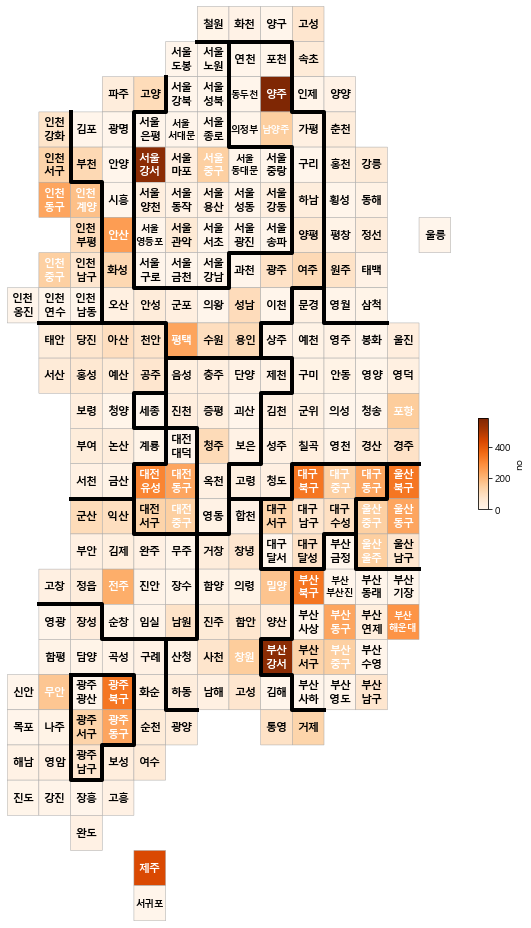

In [211]:
data1['지역'] = data1['보호센터 주소'].apply(lambda x : x.split()[1] if x else '')
data1_group = data1.groupby('지역').count()[['no']].drop('').reset_index().rename(columns = {'지역' : '행정구역'})

result = pd.merge(data_draw_korea, data1_group, how = 'left').fillna(0)

drawKorea('no', result, '광역시도', '행정구역', 'Oranges')